In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scipy.cluster.hierarchy as sch
import seaborn as sns
import xarray as xr
from fastparquet import ParquetFile
from scipy.sparse import coo_matrix, save_npz
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, normalize

from seisnet.dataloaders import (CorrelationTable, Normalize,
                                 create_local_session)
from seisnet.utils import get_data_dir, get_repo_dir

In [3]:
# engine, session = create_local_session(return_engine=True)

# q = "SELECT * FROM correlations;"
# df = pl.read_database(q,engine)
# df = df.rename({"waveform_id_1": "source_id", "waveform_id_2": "neighbor_id"})

# corr = df[["source_id","neighbor_id","correlation"]]
# corr.write_parquet(f"{get_repo_dir()}/wv_cc.parquet",row_group_size=5_000_000)

In [4]:
# picks_gdf.station.isin(rc_stations)
dd = pl.read_parquet(f"{get_repo_dir()}/sparse2k_deduped.parquet")



In [17]:
dd

source_id,neighbor_id
str,str
"""nc10085297--PG.AR..EH""","""nc68000656--PG.AR..EH"""
"""nc10085297--PG.AR..EH""","""nc68002778--PG.AR..EH"""
"""nc10085297--PG.AR..EH""","""nc68001732--PG.AR..EL"""
"""nc10085297--PG.AR..EH""","""nc68000651--PG.AR..EH"""
"""nc10085297--PG.AR..EH""","""nc68001732--PG.AR..EH"""
…,…
"""nc73972871--BG.JKR..DP""","""nc73978066--BG.JKR..DP"""
"""nc73972871--BG.JKR..DP""","""nc73978061--BG.JKR..DP"""
"""nc73972871--BG.JKR..DP""","""nc73978731--BG.JKR..DP"""


In [5]:
dfcc = pl.read_parquet(f"{get_repo_dir()}/wv_cc.parquet")
dfcc = dfcc.filter(pl.col("correlation").is_not_null())

# df = df.to_pandas()

In [6]:
dfev = pl.read_csv(f"{get_data_dir()}/metadata/picks.csv")
dfev = dfev[["event_id","station_id","azimuth", "back_azimuth", "distance_km", "elevation_m",
             "depth_km", "local_depth_m", "latitude", "longitude", "snr", "takeoff_angle"]]
dfev = dfev.with_columns(
    pl.col("snr")
    .str.strip_chars("[ ]")
    .str.replace_all(r"\s+", ",")
    .str.split(",")
    .list.eval(pl.element().cast(pl.Float64)).list.mean()
    .alias("snr")
)

In [7]:
# Assuming your main dataframe is called `df`
source_unique = dfcc.select("source_id").unique().with_row_index(name="source_idx")
neighbor_unique = dfcc.select("neighbor_id").unique().with_row_index(name="neighbor_idx")

# Join to get `source_idx`
df_mapped = dfcc.join(source_unique, on="source_id", how="left")

# Join to get `neighbor_idx`
df_mapped = df_mapped.join(neighbor_unique, on="neighbor_id", how="left")



In [8]:
rows = df_mapped["source_idx"].to_numpy()
cols = df_mapped["neighbor_idx"].to_numpy()
data = df_mapped["correlation"].to_numpy()

sparse_corr = coo_matrix((data, (rows, cols)),
                         shape=(source_unique.height, neighbor_unique.height))

In [9]:
dfs = neighbor_unique.with_columns(
    pl.col("neighbor_id")
    .str.split_exact("--", 1)
    .struct.rename_fields(["event_id", "station_id"])
    .alias("fields")
).unnest("fields")

In [10]:
X_phy_feat =  dfs.join(dfev, on=["event_id","station_id"], how="left")\
    .drop(["neighbor_idx","neighbor_id","event_id","station_id"])#,"longitude","latitude"])
# 

In [11]:
# Scale the physical features
scaler = StandardScaler()
X_feat_scl = scaler.fit_transform(X_phy_feat)

# Reduce dimensionality with sparse-aware SVD
svd = TruncatedSVD(n_components=100)
X_corr_red = svd.fit_transform(sparse_corr.transpose())
X_corr_norm = normalize(X_corr_red)        # (Optional) Normalize the features

# Combine the physical and cross correlation features together
X_combo = np.hstack([X_corr_norm, X_feat_scl,])

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_combo)

In [ ]:
pldt = X_phy_feat.with_columns(
    pl.Series("labels",labels)
)
# pldt = pldt[["longitude","latitude","labels"]]
# plt.scatter(labeled.longitude,labeled.latitude, c=labeled.labels)
# plt.show()

In [39]:
pldt

longitude,latitude,labels
f64,f64,i32
-120.536613,36.009418,3
-118.959755,37.617115,4
-122.765747,38.770721,0
-122.856873,38.827545,0
-121.096786,36.661072,3
…,…,…
-122.875687,38.858528,2
-120.840836,35.212166,3
-119.021309,37.612782,1


In [38]:
np.unique(labels)

array([0, 1, 2, 3, 4], dtype=int32)

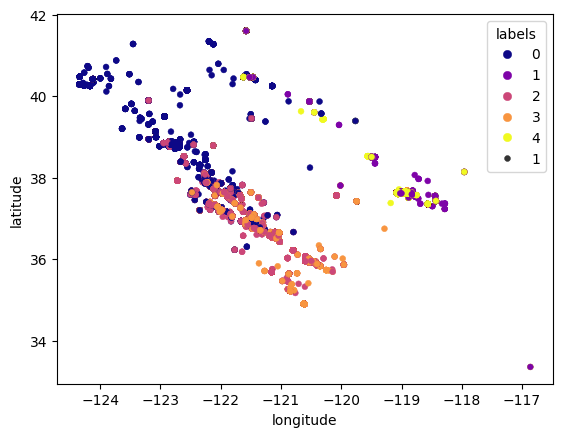

In [36]:
sns.scatterplot(x="longitude", y="latitude", data=pldt, hue="labels", size=1, ec=None, palette="plasma")
plt.show()

In [42]:
pd.DataFrame({"labels":labels}).value_counts()

labels
0         75316
4         64627
2         40237
3         37277
1         27763
Name: count, dtype: int64

In [16]:
sparse_corr

<COOrdinate sparse matrix of dtype 'float64'
	with 37471683 stored elements and shape (56635, 245220)>

In [12]:
dense = sparse_corr.toarray()

In [ ]:
pairwise_distances = sch.distance.pdist(dense)
linkage = sch.linkage(pairwise_distances, method='complete')
cluster_distance_threshold = pairwise_distances.max()/2
idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, criterion='distance')
idx = np.argsort(idx_to_cluster_array)

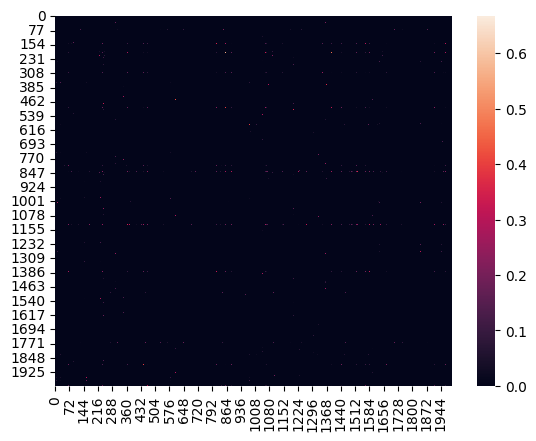

In [16]:
n = 1000
nn = n + 2000

sns.heatmap(np.abs(dense[n:nn,n:nn]))
plt.show()

In [ ]:

da = xr.DataArray(
    dense,
    dims=["source_id", "neighbor_id"],
    coords={
        "source_id": source_unique["source_idx"].to_numpy(),
        "neighbor_id": neighbor_unique["neighbor_idx"].to_numpy()
    },
    name="correlation"
)

In [8]:
da.mean()

<xarray.DataArray 'correlation' ()> Size: 8B
array(-3.72285925e-07)

In [ ]:
np.nanmin(dense[::100,::100]),np.nanmax(dense[::100,::100])

(np.float64(-0.6421861052513123), np.float64(0.8652209043502808))

In [16]:
np.nanmean(dense)

: 

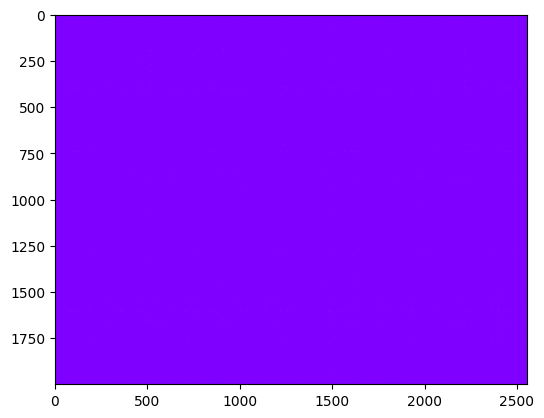

In [ ]:
cmap = plt.cm.rainbow.copy()  # Get a copy of a colormap
cmap.set_bad('white')

plt.imshow(np.abs(dense[3000:5000,3000:5000]),cmap=cmap,vmin=0, vmax=1)
plt.show()

In [4]:
len(df["source_id"].unique()),len(df["neighbor_id"].unique())

(59550, 255473)

In [3]:
sparse_dtype = pd.SparseDtype(np.float64, np.nan)
df["correlation"] = df["correlation"].astype(sparse_dtype)

In [4]:
pvtdf = df.pivot(index="source_id",columns="neighbor_id",values="correlation")

/var/folders/7j/_nb3hp3x1gd55zvfzstp5vvw0000gp/T/ipykernel_62159/2797929660.py:1: PerformanceWarning: The following operation may generate 15213417150 cells in the resulting pandas object.
  pvtdf = df.pivot(index="source_id",columns="neighbor_id",values="correlation")


: 

In [6]:
dfp = corr.pivot("neighbor_id", index="source_id", values="correlation")

: 

In [5]:
lf = corr.lazy()

# Pivot: rows = source_id, columns = neighbor_id, values = correlation
pivoted = (
    lf.pivot(
        values="correlation",
        index="source_id",
        columns="neighbor_id",
        aggregate_function="first"  # Or "mean" if duplicates expected
    )
)

# Collect the result into an eager DataFrame
corr_mat = pivoted.collect()

# (Optional) Fill nulls if needed
corr_mat = corr_mat.fill_null(0.0)


AttributeError: 'LazyFrame' object has no attribute 'pivot'

In [18]:
df

id,source_id,neighbor_id,correlation
i64,str,str,f64
1,"""nc10089291--PG.LM..EH""","""nc68000059--PG.LM..EH""",-0.074714
2,"""nc10089291--PG.LM..EH""","""nc68000059--PG.LM..EL""",-0.012255
3,"""nc10089105--PG.LM..EH""","""nc68000059--PG.LM..EH""",0.041827
4,"""nc10089105--PG.LM..EH""","""nc68000059--PG.LM..EL""",0.001913
5,"""nc10090378--PG.DC..EL""","""nc205900--PG.DC..EH""",0.038025
…,…,…,…
38604182,"""nc21359248--NC.GDX..EH""","""nc71984276--NC.GDXB..HH""",-0.194379
38604183,"""nc21359248--NC.GDX..EH""","""nc72545870--NC.GDXB..HH""",0.068166
38604184,"""nc21359248--NC.GDX..EH""","""nc73166435--NC.GDXB..HH""",-0.126393


In [ ]:
corr_matrix = df.pivot(index="source_id", on="neighbor_id", values="correlation")

# Optional: fill NaNs with 0 or another placeholder
corr_matrix_filled = corr_matrix.fillna(0)

/var/folders/7j/_nb3hp3x1gd55zvfzstp5vvw0000gp/T/ipykernel_93933/1020862584.py:1: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  corr_matrix = df.pivot(index="source_id", columns="neighbor_id", values="correlation")


: 

In [ ]:
# df_filt = sparse.join(df, on=["source_id", "neighbor_id"], how="anti")

: 

In [2]:
pf = ParquetFile(f"{get_repo_dir()}/sparse2k_deduped.parquet")

In [3]:
len(pf.row_groups),pf.count()

(86, 853275758)

In [79]:
for i in pf.iter_row_groups():
    print(i)

                      source_id             neighbor_id
0           nc110639--PG.DC..EH     nc205900--PG.DC..EH
1           nc110639--PG.DC..EH     nc205900--PG.DC..EL
2           nc110639--PG.DC..EH   nc21451733--PG.DC..EH
3           nc110639--PG.DC..EH   nc21451733--PG.DC..EL
4           nc110639--PG.DC..EH   nc30067904--PG.DC..EH
...                         ...                     ...
1119385  nc21022578--NC.MEM..EH  nc71597920--NC.MEM..EH
1119386  nc21022578--NC.MEM..EH  nc71597920--NC.MEM..EL
1119387  nc21022578--NC.MEM..EH  nc71615510--NC.MEM..EH
1119388  nc21022578--NC.MEM..EH  nc71649476--NC.MEM..EH
1119389  nc21022578--NC.MEM..EH  nc71649476--NC.MEM..EL

[1119390 rows x 2 columns]
                      source_id             neighbor_id
0        nc21022578--NC.MEM..EH  nc71658401--NC.MEM..EH
1        nc21022578--NC.MEM..EH  nc71658401--NC.MEM..EL
2        nc21022578--NC.MEM..EH  nc71685015--NC.MEM..EH
3        nc21022578--NC.MEM..EH  nc71685015--NC.MEM..EL
4        nc21022578-

In [3]:
sparse = pl.read_parquet(f"{get_repo_dir()}/sparse2k_deduped.parquet",)

In [4]:
sparse

source_id,neighbor_id
str,str
"""nc10085297--PG.AR..EH""","""nc68000656--PG.AR..EH"""
"""nc10085297--PG.AR..EH""","""nc68002778--PG.AR..EH"""
"""nc10085297--PG.AR..EH""","""nc68001732--PG.AR..EL"""
"""nc10085297--PG.AR..EH""","""nc68000651--PG.AR..EH"""
"""nc10085297--PG.AR..EH""","""nc68001732--PG.AR..EH"""
…,…
"""nc73972871--BG.JKR..DP""","""nc73978066--BG.JKR..DP"""
"""nc73972871--BG.JKR..DP""","""nc73978061--BG.JKR..DP"""
"""nc73972871--BG.JKR..DP""","""nc73978731--BG.JKR..DP"""


In [ ]:
df_iter = sparse.iter_rows()

In [15]:
from itertools import islice
batch_size = 10
# list(islice(df_iter, batch_size)),
aa = list(islice(df_iter, batch_size))

aa[0][0]

'nc10087775--PG.PS..EH'

In [6]:
def remove_duplicated_reverse_pairs(df):
    # Normalize each pair to ensure (A, B) and (B, A) are treated as equal
    normalized_df = df.select([
        pl.when(pl.col("source_id") < pl.col("neighbor_id"))
        .then(pl.col("source_id"))
        .otherwise(pl.col("neighbor_id"))
        .alias("id1"),

        pl.when(pl.col("source_id") < pl.col("neighbor_id"))
        .then(pl.col("neighbor_id"))
        .otherwise(pl.col("source_id"))
        .alias("id2")
    ])

    # Drop duplicates on the normalized columns
    unique_pairs = normalized_df.unique()

    # Rename back to your original column names
    final_df = unique_pairs.rename({
        "id1": "source_id",
        "id2": "neighbor_id"
    })

    return final_df

df = remove_duplicated_reverse_pairs(sparse)

: 

In [2]:
def remove_duplicated_reverse_pairs_lazy(path):
    lf = pl.scan_parquet(path)

    normalized = lf.select([
        pl.when(pl.col("source_id") < pl.col("neighbor_id"))
          .then(pl.col("source_id")).otherwise(pl.col("neighbor_id")).alias("id1"),

        pl.when(pl.col("source_id") < pl.col("neighbor_id"))
          .then(pl.col("neighbor_id")).otherwise(pl.col("source_id")).alias("id2")
    ])

    return (
        normalized
        .unique()
        .rename({"id1": "source_id", "id2": "neighbor_id"})
        .collect()
    )

sparse = remove_duplicated_reverse_pairs_lazy(f"{get_repo_dir()}/sparse2k.parquet copy")

: 

In [13]:
sparse

source_id,neighbor_id
str,str
"""nc10089105--PG.LM..EH""","""nc68000059--PG.LM..EH"""
"""nc10089105--PG.LM..EH""","""nc68000059--PG.LM..EL"""
"""nc10089105--PG.LM..EH""","""nc68008775--PG.LM..EH"""
"""nc10089105--PG.LM..EH""","""nc68008938--PG.LM..EH"""
"""nc10089105--PG.LM..EH""","""nc68014741--PG.LM..EH"""
…,…
"""nc73365035--BK.SAO.00.HH""","""nc73946980--BK.SAO.00.HH"""
"""nc73365035--BK.SAO.00.HH""","""nc73947150--BK.SAO.00.HN"""
"""nc73365035--NC.BJOB..EH""","""nc73231836--NC.BJOB..EH"""


In [1]:
import duckdb
import polars as pl

from seisnet.utils import get_repo_dir

con = duckdb.connect()

datapath = f"{get_repo_dir()}/sparse2k.parquet"
outpath = f"{get_repo_dir()}/sparse2k_deduped.parquet"
query = f"""
COPY (
    SELECT DISTINCT
        LEAST(source_id, neighbor_id) AS source_id,
        GREATEST(source_id, neighbor_id) AS neighbor_id
    FROM '{datapath}'
    ORDER BY source_id
)
TO '{outpath}'
(FORMAT parquet, COMPRESSION zstd, ROW_GROUP_SIZE 10_000_000);
"""

arrow_table = con.execute(query)


In [6]:
df_polars

source_id,neighbor_id
str,str
"""nc21174043--NC.GDX..EH""","""nc72766241--NC.GDXB..HH"""
"""nc21174043--NC.GDX..EH""","""nc72800981--NC.GDXB..HH"""
"""nc21174043--NC.GDX..EH""","""nc72831961--NC.GDXB..HH"""
"""nc21174043--NC.GDX..EH""","""nc72856446--NC.GDXB..HH"""
"""nc21174043--NC.GDX..EH""","""nc72871800--BG.FUM..DP"""
…,…
"""nc73395356--BG.SB4..DP""","""nc73972866--BG.SB4..DP"""
"""nc73509790--BG.BUC..DP""","""nc73972866--BG.SB4..DP"""
"""nc73760091--BG.US3..DP""","""nc73972866--BG.SB4..DP"""
